<a href="https://colab.research.google.com/github/victorviro/Machine-Learning-Python/blob/master/ML_experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML experimentation

# Table of contents


1. [Introduction](#1)
2. [Planning experiments](#2)
    0. [Data sources](#2.0)
    1. [Setup environment](#2.1)
    2. [Basic visualization](#2.2)
    3. [Research phase](#2.3)
    4. [Forget blogs. Read API docs](#2.4)
    5. [Quick testing and rough estimates](#2.5)
    6. [Rules and boundaries](#2.6)
3. [Experimental preparation work](#3)
    1. [Data analysis](#3.1)
    2. [Data cleanliness](#3.2)
    3. [Moving to reusable code](#3.3)
        1. [When functions should be created?](#3.3.1)
4. [Testing ideas](#4)
    1. [Setting guidelines in code](#4.1)
        1. [Baseline comparison](#4.1.1)
        2. [Standard metrics](#4.1.2)
        3. [Create validation set](#4.1.3)
    2. [Running quick tests](#4.2)
        1. [Rapid test for Exponential smoothing](#4.2.1)
5. [Evaluation](#5)
    1. [Evaluating prototypes properly](#5.1)
    2. [Direction we are going in](#5.2)
6. [What is next?](#6)
7. [References](#7)






# Introduction <a name="1"></a>

In the notebook [Planning and scoping ML projects](https://nbviewer.jupyter.org/github/victorviro/Machine-Learning-Python/blob/master/Planning_and_scoping_ML_projects.ipynb), we focused on the processes surrounding planning and scoping ML projects. This notebook will focus on the next critical aspect of ML work: **research and experimentation**.

**Once** as much as possible project’s **requirements have been captured** from planning meetings **and the goal** of the solution has been **defined**, the **next phase is** to begin **experimentation and research**. While **there is** no a concrete **rule for estimating exactly how long an experimentation phase should last**, a good structure and methodology will guarantee a reduction in the amount of time to reach a favorable MVP state and a reduction in the amount of duplicate effort that a team would face.

We’ll be seeing how to **organize and plan** appropriate **research and setting expectations** and rules within the planning phase, and finally, how to conduct our experiments and build utilities for the project. These stages are designed for an easier development period and to minimize the risk of creating technical debt from the start of the project, and also minimizing the risk of project abandonment.

The aspects that we’re covering are **generally applicable to all ML work**.

As with all things in software development, a quality **project starts with planning**.

# Planning Experiments <a name="2"></a>

At this point, the meetings have been conducted, the requirements have been gathered, and the ML team has discussed the project. Suppose we want to solve a demand forecast time series prediction problem. But **where do we start**, now that we know the problem we’re trying to solve? **We have 2 weeks to come up with an MVP** to show that we have a proven approach to solve this problem.

The next figure shows a **roadmap of the ML Experimentation planning**.

![](https://i.ibb.co/0mN73X4/ML-experimentation-planning.png)

## Data sources <a name="2.0"></a>

With business objectives defined, the next step is the **search for suitable input data. Key questions for finding data** to build ML models include: 

- What relevant datasets are available?
- Is this data sufficiently accurate and reliable?
- What features can be made available by combining multiple sources of data?
- Will this data be available in real time?
- Is there a need to label some of the data with the "ground truth"? If so, how much will this cost in terms of time and resources?
- How will data be updated once the model is deployed?
- How will the KPIs be measured?

The constraints of data governance bring even more questions, including: 
- Can the selected datasets be used for this purpose?
- What are the terms of use?
- Is there personally identifiable information (PII) that must be redacted or anonymized?

## Set up environment <a name="2.1"></a>

The experimentation is usually done in Jupyter notebooks. We need to set up the environment where we are going to do the experimentation. It could be:

- A clean virtual environment.

- A docker container. [Docker](https://www.docker.com/) is a containerization service that allows for an operating **system-level virtualization**, can be configured with resources from the machine that it is running on and can have **full isolation** from other applications and operating system on the host machine. This allows us to **package our software dependencies and libraries** needed to run our code. It also allows us to **run the container in any environment** (on-premise, cloud-based server). This introduces **portability** to ML project work which is important in not only the experimentation phases but also is becoming critical for production-scale ML.

Once we have an isolated environment, we can get the sample data and create a new notebook for experimentation.

## Basic visualization <a name="2.2"></a>

The first thing that the team is going to do is look at the available data. We can **visualize the dataset and run a few statistical analyses**. At this point we can start thinking **what the plans are going to be for the experimentation phase, divining questions that should be answered to inform the research** and understand our modeling options. 

The answers to these questions can help to create an effective experimentation phase for the project. Jumping directly to model creation and testing of random ideas too early can create a great deal of wasted work that sets the delivery for an MVP back in terms of meeting the deadlines. It will always be better to **spend our time understanding the nature of our data set and uncover any hidden issues** with it ** before researching potential solutions**, as this phase can help reduce the amount of testing and additional research by culling options early.

If we would face a classical regression problem, we could visualize the distribution of the target variable (some algorithms require that the distribution of the target variable is normal). If we would face a classification task, we could check if the dataset is balanced.

For our forecasting prediction problem, we’ll get a very simple visualization of the time series trend, showing the monthly passengers that have made domestic flights inside the U.S. from 1977 to 2015 in the airport JFK. The dataset is available in this [repository](https://github.com/alan-turing-institute/TCPD/tree/master/datasets/jfk_passengers).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [ ]:
dataset_url = ('https://raw.githubusercontent.com/alan-turing-institute/TCPD/master/datasets/jfk_passengers/'
                'air-passenger-traffic-per-month-port-authority-of-ny-nj-beginning-1977.csv')
raw_data = pd.read_csv(dataset_url)
print(raw_data.shape)
raw_data.head(2)

(1584, 6)


,Airport Code,Year,Month,Domestic Passengers,International Passengers,Total Passengers
0,ACY,2015,Jan,98177,90,98267
1,ACY,2015,Feb,96431,65,96496


In [ ]:
raw_data = raw_data.copy(deep=False)
# Convert the Month column to numerical variable
raw_data['Month'] = pd.to_datetime(raw_data['Month'], format='%b').dt.month
raw_data.loc[:, 'Day'] = 1
# Add a column date
raw_data['date'] = pd.to_datetime(raw_data[['Year', 'Month', 'Day']])

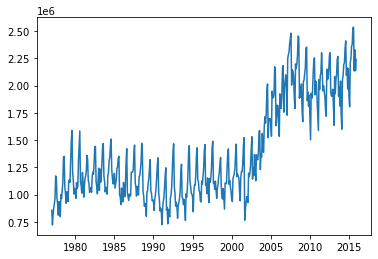

In [ ]:
# Plot the time series for the Airport "JFK"
jfk_data = raw_data[raw_data['Airport Code'] == 'JFK']
# Order the dataframe by date 
jfk_data = jfk_data.sort_values('date', ascending=True)
jfk_data.set_index('date', inplace=True)
plt.plot(jfk_data['Domestic Passengers'])
plt.show()

For our forecasting problem, some data observations and questions are:

- Latent factors are influencing the trend. It doesn’t look stationary.
- There seems to be a strong seasonality component.
- What models are good for this use case?
- We have two weeks to come up with a direction on how to approach this. Can we get this done?

## Research phase <a name="2.3"></a>

Now that we know some concerns in the data, we can start researching. **Suppose** that **no one on the team has ever solved a similar problem before. Where should research begin?** Internet searches are great, but **most** search results show **blog posts** of people showing solutions that **omit the complexities involved in building a full solution**. **White papers** can be informative, but **generally don’t focus on the applications** of the algorithms. Script examples from **"getting started" guides** for different APIs are good for seeing the mechanics of the API but **are intentionally simple** to serve as a very basic point.

The short answer is **books**. In-depth blogs can help as well, but they should be used as an initial approach foundation to the problem at hand, rather than as a repository to directly copy code from. For the time series forecasting example, we can look at books ("Time Series Analysis" by Box and Jenkins, which is widely considered to be the foundation of modern time series forecasting models, with the Box-Jenkins methodologies).

**After a bit of research** into the problem, **we'll find different options** that seem commonly used. 

For our time series forecasting, we found several options:

- Linear Regression (OLS, Ridge, Lasso, ElasticNet, and Ensemble)
- ARIMA (Autoregressive Integrated Moving Average)
- Exponential Smoothing (Holt-Winters)
- VAR (vector autoregressions)
- SARIMA (Seasonal Autoregressive Integrated Moving Average)

The **next step** is to figure out **what packages have these algorithms** and read through their API documentation. 

## Forget the blogs – read the API docs <a name="2.4"></a>

We must not believe so thoroughly in the veracity of a blog post and base an entire project around the methodology or code of that blog post. While almost always well-intentioned, authors of short **blog posts** on ML topics **don't cover deeply all of the information that is required for a real-world production ML solution**. Blogs are good. They help introduce new concepts and provide inspiration. But **they’re usually digestible, concise, and simple**, so the finer details tend to be omitted.

Additional sources of information need to be checked and vetted. Academic **papers, API tutorials**, published **books** on the subject, and, most critically, an effective testing and validation phase of the approach by the team is required.

**Note**: **There are** some truly **great blog posts** on the internet surrounding ML. Unfortunately, these are **drowned out by blogs filled with** overly simple **proofs-of-concept, broken code, or unintentionally bad programming practices**.

Once we have listed out the modeling approaches that we want to test, we should **look at the API documentation** for the module that we’re using. This isn’t to say that we should read every API doc for each module we’re ever going to use, but **at least the main interface level** (becoming familiar with the classes that we’re using, and the methods within those classes, their signatures, etc). 

We'll probably find that there are **hyperparameters** for the model that are important to tune. While for some ML algorithms, the default values are good for some common structures of data being passed into them, it’s always best to verify **what they are, what they are used for, and how identifying ones that should be tuned to build an effective model**. 

**A critical function of API docs is in informing what options are for controlling the behavior of the software** (for ML, the algorithms’ learning patterns). Without understanding how to control the model’s learning behavior, we run the risk of building models that overfit or underfit the training data, and it will make the solution useless to a business. 

Understanding how to tune and control the behavior of the model properly in the early stages of experimentation is critical, even though the act of **fine-tuning it is not necessary during this phase**.

## Quick testing and rough estimates <a name="2.5"></a>

Reading all of the documentation and running **extensive hyperparameter tuning** of a model **isn’t needed** in the experimentation testing phase, **when the team is testing different approaches**. We can **use** most of **the defaults and see what the results are**. We can just **leave a TODO in the code to, when ready to move towards full tuning of a model** for the MVP phase, **make sure that the API doc is checked** and the optional settings are validated and tested.

The **focus** here should be **on speed and not on accuracy** (we work for a company, results are expected, and there are likely other projects to work on). There will be time during the MVP phase to build out better accuracy, clever feature engineering, and creative approaches to the problem. Our time will be much better spent focusing our energy on **culling the list of options so that we have one or two candidate solutions**, rather than spending a big amount of time fine-tuning 9 (or more) different approaches.

## Rules and boundaries <a name="2.6"></a>

**Setting boundaries around testing is critical**, particularly as a team grows in number and project complexity grows as the team matures in experience. **If everyone is left to just "figure out the best solution", there will be duplicated work and excessive effort on particular solutions**.

We have a list of potential solutions for our problem, how do we go about testing them? The approach should be the same.

- Set an amount of time to do the testing, so that a decision can be made quickly on the efficacy of the solution.
- Everyone must use the same data set.
- Everyone must use the same evaluation metrics.
- The experimentation code needs to be re-runnable from scratch.
- Make sure that the language being chosen is supportable by the team and the platform.

Specifically, for our forecasting time series modeling:
- Each evaluation needs to forecast over the same time period.
- Visualizations of the forecast, along with metrics, need to be provided.

We have some rules for the forecasting problem:

- 1 week of testing, with a final review by the entire team.
- The data to be modeled is for JFK Domestic Passengers.
- The evaluation metrics will be: mean absolute error (MAE), mean absolute percentage error (MAPE), mean squared error (MSE), and R-squared.
- The forecast period for evaluation will be the last 5 years of the data set.
- Experimentation will be done in Jupyter notebooks running Python3 in a Docker container.

We need to ensure that we’re playing fairly. This means that we’re **comparing using the same data set**, and we’re evaluating the test data against the predictions with the **same metrics**. **This will prevent indecision** among the team **when measuring the effectiveness of a solution**.

Since we’re looking at a time series problem, we’re going to be evaluating a regression problem. To do a comparison, we need to control the data splits, and the evaluation metric. The team has agreed to use MAPE as the comparison metric. They have also agreed to capture as many regression metrics as apply to a time series regression problem, should they choose to switch to a different metric later.

There are a lot of opinions on the "best metrics" to use for different ML problems. However, **calculating errors is usually cheap and fast. It doesn’t hurt to calculate all of the applicable ones** and recording them. During the process of building out a solution and tuning it, **the team may decide to use a different metric**. Having these metrics there from the beginning can give a historical reference for each run that was attempted without having to go back to re-run experiments just to collect additional metrics. The only **exception** to collect all the metrics is **if the metric evaluation is of such an expensive (computationally) nature** that the benefit that it provides outweighs the cost of calculating it.

# Experimental preparation work <a name="3"></a>

After the phase of planning and research, the next phase is the preparation for experimental testing. It is focused on a **deep analysis of the data sets, and creating common tools** that the entire team can use to increase the speed at which they can evaluate their experimental attempts.

We already have decided on some models to try, set rules for the experimentation phase, selected our language (Python) and our platform (Jupyter notebooks running on a Docker container). **Before we start with a bunch of modeling tests, it’s important to understand the data as it relates to the problem**. 

That typically means going through an exploratory data analysis (**EDA**) (distribution of variables, relationship between variables,...), **checking missing and outlier values**, etc. It will also help to **build some basic visualization tooling** that will aid in the rapid phases of model testing that the sub-teams will be doing.

The importance of doing this preparation work ahead of time is to **inform our testing**. It is to guide the testing so that we can rapidly iterate on experiments from a position of knowledge about the data, thereby getting answers about approaches and their applicability to the problem faster. We’ll evaluate different approaches, and the faster that we can determine which of those are the 2 most promising candidates, the faster we can ignore the others and, collectively as a team, make progress towards our deadline for an MVP for the business.

The next figure shows the **stages of preparation work** that will ensure each of our teams will have an efficient development process and won’t be focused on creating 9 different copies of the same way of plotting and scoring their results. This figure depends on the type of ML project at hand. Each step is fairly applicable for any supervised ML problem.

![](https://i.ibb.co/RYM65SV/analysis-experimentation-ML.png)

## Data analysis <a name="3.1"></a>

**Visualizations** are helpful to **minimize unforeseen issues with the data that might be uncovered much later** in the project that could require a complete rework of the solution.

For the forecasting project, we are going to perform an analysis of stationarity tests, and a  decomposition of the trend. Based on the initial visualization we built earlier, we noticed there is noise in the data set. Visualize the general trend line can help, so let’s start applying a smoothing function to the raw data trend for the Domestic Passengers at JFK.

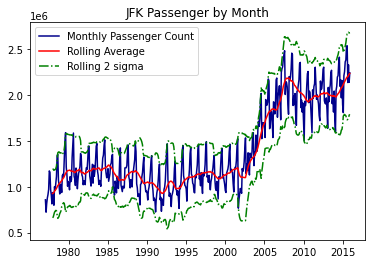

In [ ]:
rolling_average = jfk_data['Domestic Passengers'].rolling(12, center=False).mean()
rolling_std = jfk_data['Domestic Passengers'].rolling(12, center=False).std()
plt.plot(jfk_data['Domestic Passengers'], color='darkblue', 
         label='Monthly Passenger Count')
plt.plot(rolling_average, color='red', label='Rolling Average')
plt.plot(rolling_average + (2 * rolling_std), color='green', linestyle='-.', 
         label='Rolling 2 sigma')
plt.plot(rolling_average - (2 * rolling_std), color='green', linestyle='-.')
plt.legend(loc='best')
plt.title('JFK Passenger by Month')
plt.show(block=False)

There is a step function that occurs around 2002. Also, the standard deviation varies during different time periods (after 2008, the variance becomes broader than it had historically).

During the research phase, we found many mentions of stationarity in time series and how certain model types can struggle with predicting a non-stationary trend. We are going to use the [Augmented Dickey-Fuller stationarity test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test), provided in the statsmodels module. This test will inform us of whether or not we will need to provide stationarity adjustments to the time series for particular models that are incapable of handling non-stationary data.

If the time series is stationary, all models can use the "raw data" with no transformations applied to it. However, if the data is non-stationary, there will be some extra work required.

In [ ]:
!pip install statsmodels==0.11.0

In [ ]:
from statsmodels.tsa.stattools import adfuller

dickey_fuller_test = adfuller(jfk_data['Domestic Passengers'], autolag='AIC')
test_statistic, p_value, lags = dickey_fuller_test[:3] 
print(f'Test statistic: {test_statistic}')
print(f'P-value: {p_value}')
print(f'Lags: {lags}')
if p_value > 0.05:
    print("Serie is not stationary")
else:
    print("Serie is stationary")

Test statistic: -0.0498716198369983
P-value: 0.9542082208500818
Lags: 13
Serie is not stationary


The null hypothesis of this test is that the time series is non-stationary. As the p-value is bigger than the significance level (`0.05`), we cannot reject the null hypothesis and we conclude that the time series is non-stationary.

An explanation of how statistical tests work and how we interpret them is available in the notebook [Statistical tests with python](https://nbviewer.jupyter.org/github/victorviro/Machine-Learning-Python/blob/master/Statistical_hypothesis_tests_in_Python.ipynb). The theory behind this specific test is available in the papers "Efficient Tests for an Autoregressive Unit Root" and "Distribution of the Estimators for Autoregressive Time Series with a Unit Root")

There’s also other interesting information: the number of lags. It can help us in figuring out settings that we should be using when we get to the modeling phase with ARIMA-based models. The number 13 seems a bit odd, considering that we’re looking at monthly data. If we were to blindly just use that value as a seasonality (period) component in our models, we would probably get some terrible results. We can validate this though by looking at some trend decompositions below.

We’re going to see if we can effectively decompose the trend, seasonality, and residuals in the signal with the built-in functionality in statsmodels, helping to inform some of the settings that we will need to use in the modeling experiments.

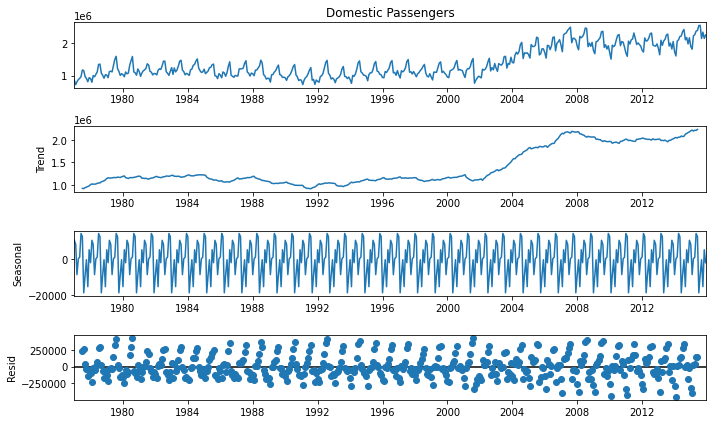

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed_trends = seasonal_decompose(
    x=jfk_data['Domestic Passengers'], 
    period=13
)
plt.rc("figure", figsize=(10,6))
trend_plot = decomposed_trends.plot()

It seems like there is a pattern in the residuals. Residuals should be the "unexplained noise" that is left over after the general trend and the seasonality are extracted from the data.

Let’s try a different run of this, but setting the `period=12`.

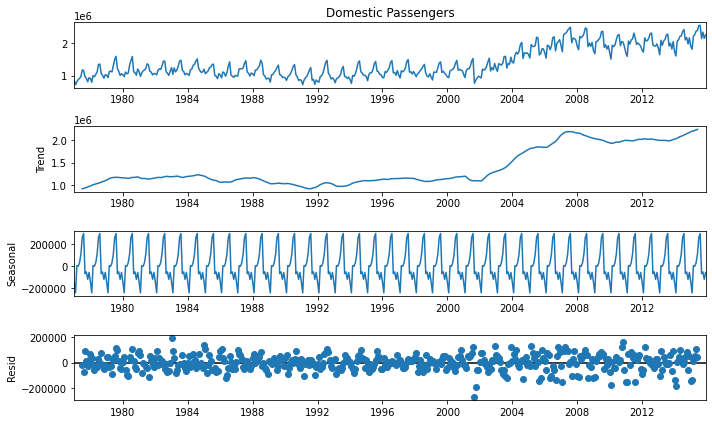

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed_trends = seasonal_decompose(
    x=jfk_data['Domestic Passengers'], 
    period=12
)
trend_plot = decomposed_trends.plot() 

That looks better. Our trend is nice and smooth, our seasonality looks well matched to the periodicity of the repeated pattern in the data, and the residuals are (mostly) random.

There are two additional plots that could inform us of what
initial settings we should use for some of the model types that we’ll be testing out in our forecasting problem: autocorrelation and partial autocorrelation. The statsmodel module has built-in methods to generate these plots.

## Data cleanliness <a name="3.2"></a>

Data cleanliness is crucial to **identify bad data points for modeling training effectiveness**, but it can also help to tell a story to the business about why certain outputs of the model might be less than accurate at times. Building a series of visualizations that can communicate the complexities of latent factors, data quality issues, and other unforeseen elements that can affect the solution can serve as a powerful tool during discussions with the business unit that the project is being built for.

We could build functions to **identify outlier values, check missing values and replace them** using different methods, etc.

One important thing that we’re going to have to explain about the forecasting project is that it won't be an infallible system. There are unknowns in our data; elements that influence the trend that are too complex to track, too expensive to model, or nearly impossible to predict that would be needed to feed into the algorithm. An easy way to identify outlier values with our time series (with a seasonally influenced trend) would be to use a differencing function on the sorted data.

## Moving to reusable code <a name="3.3"></a>

**Until now, the code written** for data preparation and basic visualizations of our JFK Domestic Passenger data **was a bit rough** and reads like a script. That’s **fine for doing a quick check** on things and understandable **for the early stages of experimentation**. However, when the team breaks off to work on their modeling activities, it will be incredibly wasteful for everyone to be building their visualizations, their implementations of similar tests, and just wasting time building code that can be easily rolled into some standard functions. The last thing we (should) want is to have a disparate collection of notebooks that have multiple copies of the same code, just slightly modified, spread everywhere. Imagine if this project were being undertaken by 6 different sub-teams of Data Scientists. Standardization and **using functions** can help to reduce redundant code.

Making reusable code helps for a **cleaner code base**, and it helps to **standardize elements of the project** in preparation for the MVP (and development) phases. Reducing confusion, speeding time to decision making, and creating less chaos in notebooks and scripts are needed to maximize the chances of the business having enough faith in the project to continue development efforts on it.

It is **not recommending to, at this stage, build a package-level project** for these utility functions. That work will come later during the actual development phase of the project during the long and arduous road to production release.

In [ ]:
AIRPORT_FIELD = 'Airport Code'
 
def pull_raw_airport_data(file_location):
    raw = pd.read_csv(file_location)
    raw = raw.copy(deep=False)
    raw['Month'] = pd.to_datetime(raw['Month'], format='%b').dt.month
    raw.loc[:, 'Day'] = 1
    raw['date'] = pd.to_datetime(raw[['Year', 'Month', 'Day']])
    raw.set_index('date', inplace=True)
    raw.index = pd.DatetimeIndex(raw.index.values, freq=raw.index.inferred_freq)
    asc = raw.sort_index()
    return asc

def filter_airport_data(all_data, airport):
    filtered_data = all_data[all_data[AIRPORT_FIELD] == airport]
    return filtered_data
 
def get_airport_data(airport, file_location):
    all_data = pull_raw_airport_data(file_location)
    filtered = filter_airport_data(all_data, airport)
    return filtered
 
def get_all_airports(file_location):
    all_data = pull_raw_airport_data(file_location)
    unique_airports = all_data[AIRPORT_FIELD].unique()
    return sorted(unique_airports)

def apply_index_freq(data, freq):
    return data.asfreq(freq)

These functions can be used by sub-teams that are going to be testing out solutions to the forecasting project throughout the experimental phase. These can be modularized into a class later during the development phase to create a standardized and testable implementation for the production-grade final project.

In [ ]:
jfk_data = get_airport_data('JFK', dataset_url)
jfk_data = apply_index_freq(jfk_data, 'MS')
jfk_data.head(2)

,Airport Code,Year,Month,Domestic Passengers,International Passengers,Total Passengers,Day
1977-01-01,JFK,1977,1,856626,630962,1487588,1
1977-02-01,JFK,1977,2,722025,515694,1237719,1


To demonstrate the benefits of taking a little bit of extra time and building a function out of even experimental validation code, let’s prepare the data from a different airport, LaGuardia:

In [ ]:
laguardia_data = get_airport_data('LGA', dataset_url)
laguardia_data = apply_index_freq(laguardia_data, 'MS')
laguardia_data.head(2)

,Airport Code,Year,Month,Domestic Passengers,International Passengers,Total Passengers,Day
1977-01-01,LGA,1977,1,1093062,0,1093062,1
1977-02-01,LGA,1977,2,1020854,0,1020854,1


### When functions should be created? <a name="3.3.1"></a>

**During experimentation**, in addition to the focus of solving a problem, **there should be some consideration of what elements of the code will need to be modularized for reuse**. Not every aspect of a solution needs to be "production-ready", particularly in the early stages, but it is helpful to start thinking about what aspects of the project will need to be referenced or executed many times over.

It’s important to realize that, by taking time to create a generic reference to a repeatable task, **we could be saving ourselves a lot of hours later**. When we’ll convert our scripted solution into a properly developed ML code base, we won’t have to review so many implementations. Instead of dozens of visualizations and scoring functions, we'll be left with a group of single-purpose functions that will only need to be looked at and evaluated as a single unit.

Some of the **elements that we can typically look for to create functions** for as early as possible in the ML space are:

- Data ingestion / Data cleansing
- Scoring and error calculations
- General data visualizations
- Validation and prediction visualizations
- Model performance reports (e.g. ROC curves, confusion matrices)

The important thing to keep in mind when building even the earliest phases of a project is to either set aside the time to create reusable code immediately or to at least flag the code for implementation in such a way that makes it easy to identify for action as soon as is practicable.

In predictive modeling, most ML practitioners end up spending the vast majority of their efforts working on feature engineering, data validation, and modeling. The **process of constant code rewrites and testing can rapidly devolve into a mess of half-implemented, commented-out**, and generally unreadable sprawl of chaos. Sometimes, in the process of wanting to test something new out, it seems easier to just copy a block of code from a notebook cell far above just to simply get something to work quickly. This ends up causing a complete disjointed mess of code that is going to be a monumental undertaking to move into something eligible for further development. In these cases, the original testing code will be likely abandoned when an approach is decided upon. It doesn’t have to be that way though. **If a little care is taken during this phase, the subsequent development phases can be much more efficient**.

# Testing ideas <a name="4"></a>

In the previous section, we covered the preparatory work for an experimentation phase of a project. From conducting research that informs what options are available for solving the problem to building useful functions that the team members can leverage during the prototyping phase. In this section, we will focus on **methodologies for experimental testing** which aims to **rapidly test ideas**, using uniform **scoring methods to achieve comparability between approaches**. 

This is crucial for two primary reasons. **If not enough approaches are tested, the chosen approach may be insufficient to solve the problem**. At the other extreme, **testing too many options deeply can result in an experimental prototyping phase that takes too long**. The figure below shows these **two extremes of prototyping** within an ML project as a visual comparison, with the middle ground being the moderate approach with the highest success rates.

![](https://i.ibb.co/P94B2wx/ML-prototyping-extremes.png)

On the **left** side, the **absence of testing out different approaches** may likely lead to a **solution** that is **ill-suited** to solve the problem. On the **right** side, however, there is a different problem. While it is certainly true that **to truly judge the effectiveness of a solution is to build it out fully** (fully optimized, evaluating dozens or hundreds of experiments with feature engineered solutions), **in the reality of the business world** there simply **isn’t time for this**. The amount of time, resources, and money that will need this approach will leave a business realizing that, to get a solution to their business need, they paid for a DS team to build multiple solutions for a single problem. It is costly to a company in terms of monetary currency (both in human capital and in computing resources), and it is expensive in time.

**We need to resist the temptation to achieve perfection at this stage**: As Data Scientists, our natural inclination is to build solutions that are as optimal as possible. This is important, but for the project as a whole. During early testing phases, having a drive for perfection can be a detriment to the success of a project.
While **business sponsors** of the project also desire to have the best possible solution, they **are also focused on the time** that it takes to develop the solution (and the cost of it). They have no visibility into what we’re doing to figure out the best solution, and **don’t care how many things that we’ve tested** on the way. It is best, **at this stage, to eschew that desire** for fully exploring all of the options **and instead focus on finding the most probable approach** to solve the problem.

At this phase, the **team splits into different sub-task groups** that will focus on **implementations of the different researched options** to produce an accurate solution, and also to understand the nuances of tuning each model.

There are a few more **standard tooling functions to to be build for ensuring that everyone is evaluating the same metrics, producing the same reports** to easily show the pros and cons of the approaches. The teams can then get into the task of evaluating and researching their assigned modeling tasks, all using the same core functionality and scoring. The figure below gives an overview of **typical functionality, and standards** to be **used during the model prototyping** phase of a project.

![](https://i.ibb.co/T1c7dMx/ML-experimentation-prototyping.png)

This path of actions is generally focused on supervised learning. A prototyping phase for, say, a CNN would look a bit different, but in general, these pre-work actions and approaches to prototyping of different solutions will save weeks of frustrating rework and confusion if adhered to.

## Setting guidelines in code <a name="4.1"></a>

We already have developed some visualization tools and basic data ingestion functions (for the forecasting project) that each team can use. We built these for two primary purposes:

- **Standardization**, so that each team can **generate identical plots, and metrics** that allow **for a comparison between the different approaches**. Without standardization, we'll likely make poor decisions on which approach to go with for the MVP (and the subsequent fully developed solution), and teams are going to waste time building implementations of visualizations that do the same thing.

- **Communication**, so that we can generate referenceable visualizations to **demonstrate to the business how our modeling solutions are solving the problem**. Without communication, we would be left with confusing metric score values to report, or, in the worst case, raw code to show to the business, a recipe for disaster in a demonstration meeting.

**Non-confusing plots**: Not every person in a company likes statistics, so we **don't** want to **spout the veracity of a solution based on some complex metric or score to an executive**. **Visual representations** of data that **simplify a complex system** will be more effective **as a communication tool**. Building an effective and easy-to-comprehend visualization that conveys the respective predictive power of the algorithms in use.

As we discussed in the notebook [Planning and scoping ML projects](https://nbviewer.jupyter.org/github/victorviro/Machine-Learning-Python/blob/master/Planning_and_scoping_ML_projects.ipynb), after this phase of experimentation the team will need to provide a presentation of their findings in a way that can be easily digested by a non-technical audience. One of the best ways to do this communication is through visualizations of the prediction data, shown with the ground truth held-out testing data, rather than confusing reports and tables of test metrics. 

### Baseline comparison visualization <a name="4.1.1"></a>

To have a basic **reference for more complex models**, it can be useful to **build a simpler implementation to see if more sophisticated approaches can do better than that**. 

For our time series modeling, the baseline can be a simple moving average or an exponentially smoothed average. To create a visualization that the teams can use to see these relationships for simpler algorithms, we will first have to define an exponential smoothing function.

In [ ]:
def exp_smoothing(raw_series, alpha=0.05):
    output = [raw_series[0]]
    for i in range(1, len(raw_series)):
        output.append(raw_series[i] * alpha + (1-alpha) * output[i-1])
    return output

Now we define a function to generate a visualization of both the moving average and the exponentially smoothed data.

In [ ]:
from sklearn.metrics import mean_absolute_error

def smoothed_time_plots(time_series, time_series_name, 
                        smoothing_window, exp_alpha=0.05):

    with plt.style.context(style='seaborn'):
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))  
        moving_avg = time_series.rolling(window=smoothing_window).mean()
        mae_moving_avg = mean_absolute_error(
            y_true=time_series[smoothing_window:], 
            y_pred=moving_avg[smoothing_window:]
        )
        exp_smoothed = exp_smoothing(time_series, exp_alpha)
        exp_data = pd.Series(exp_smoothed, index=time_series.index)
        mae_exp_smooted = mean_absolute_error(
            y_true=time_series[smoothing_window:], 
            y_pred=exp_data[smoothing_window:]
        )
        axes[0].plot(time_series, '-', label=f'Trend for {time_series_name}')
        axes[0].plot(moving_avg, 'g-', 
                     label=f'Moving Average with window: {smoothing_window}')
        axes[0].set_title(f'Moving Average Trend for window: {smoothing_window}'
                          f' with MAE of: {mae_moving_avg:.1f}')
        axes[0].legend(loc='upper left')
        axes[1].plot(time_series, '-', label=f'Trend for {time_series_name}')
        axes[1].legend(loc='upper left')
        axes[1].plot(exp_data, 'g-', 
                     label=f'Exponential Smoothing with alpha: {exp_alpha}')
        axes[1].set_title(f'Exponential Smoothing Trend for alpha: {exp_alpha}'
                          f' with MAE of: {mae_exp_smooted:.1f}')
        axes[1].legend(loc='upper left')
        reference_collection = {
            "plots": fig,
            "moving_average": moving_avg,
            "exp_smooth": exp_smoothed
        }
        return reference_collection

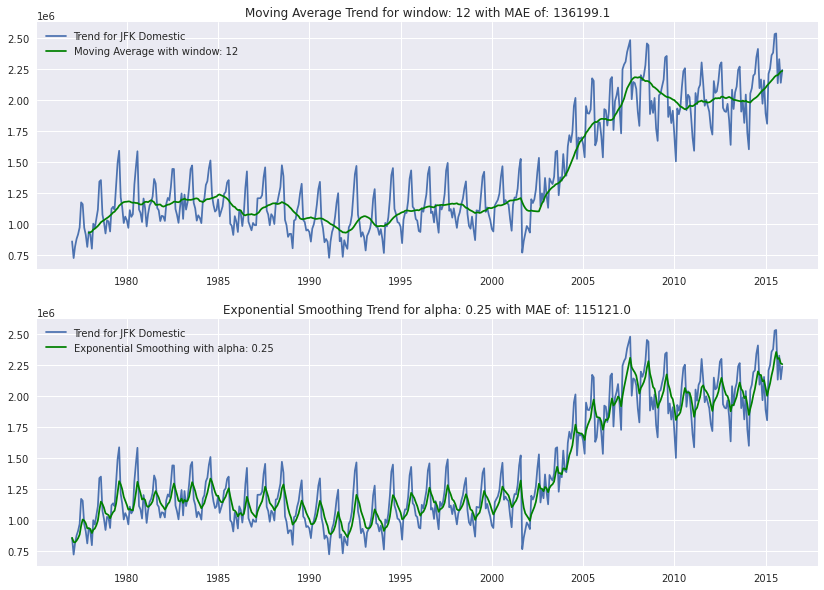

In [ ]:
jfk_data = get_airport_data('JFK', dataset_url)
jfk_reference = smoothed_time_plots(
    time_series=jfk_data['Domestic Passengers'],
    time_series_name='JFK Domestic', 
    smoothing_window=12, 
    exp_alpha=0.25
)

This function will give the sub-teams a quick **reference visualization** (and the series data to compare with). The **goal in wrapping this visualization code into a function** at this stage is:

- **Portability: each team can use as a dependency to their work**, ensuring that everyone is generating the same visualizations.

- **Preparing for production**, this function can be easily ported into a visualization class as a method that can be used for this project, and other forecasting projects in the future.

The focus on spending a little time at creating reusable code may not seem to be worthwhile at this point, particularly with the focus that we’ve been giving to the timeliness of delivery for the solution prototype, but as projects grow in scope and the complexity extends far beyond a rather simple forecasting problem, **the relatively small effort made at this point to prepare for modularized code now will save a great deal of time later on**.

### Standard metrics <a name="4.1.2"></a>

The last thing that the team needs to implement before moving to the model experimentation is the **standardized measurement of the predictions** to hold out validation data. This effort is to eliminate debate on the effectiveness of the different implementations by providing a scientific methodology for comparison. If were we to leave each team to determine their evaluation metrics, it would be nigh impossible to compare them to one another, leading to rework of tests and further project delays. We'll **build a function that will make scoring and standardized reporting of the results easier**.

In the section "Planning meetings (Rules and boundaries)", we covered the agreed-upon metrics to score the models on the time series project example: R-squared, MSE, MAE, MAPE, and explained variance. The MAPE will be used to assess the overall quality of predictions across different time series. It shouldn’t, however, be used as the only measurement metric, as we discussed earlier in planning for our experimentation. Having multiple metrics recorded for each of the experiments is helpful if we need to evaluate previous experiments based on a different metric.

We create a simple series scoring function that will calculate all of the agreed-upon metrics.

In [ ]:
!pip install scikit-learn==0.24.2

In [ ]:
from sklearn.metrics import (mean_absolute_percentage_error, mean_squared_error,
                             explained_variance_score, mean_absolute_error,r2_score)
def calculate_errors(y_true, y_pred):
    error_scores = {
        "mae": mean_absolute_error(y_true, y_pred),
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "explained_var": explained_variance_score(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }
    return error_scores

Notice that there is **no print statements** in the function defined above for some **reasons**: 

- We'll want to use the dictionary score metrics for the visualization that we’ll build for the teams to use, therefore, we don’t want to have the values simply printed to stdout. 
- It’s a **bad practice** to have stdout reporting in functions (except for temporary debugging of code) as this will create more work later when developing a solution. Digging through code prior to a release to production to scrub out print statements (or convert them to logging statements) is tedious and error-prone. Moreover, **in production, no one will ever read stdout**. The better approach for information associated with an ML run is to persist the data to a location that can be queried or visually referred to. The better alternative is to **log the results in code, or, use an experiment tracking service** like [MLFlow](https://mlflow.org/docs/latest/tracking.html#tracking).

For the final pre-modeling work, we build a **visualization and metric reporting function** that will give each of the teams a standard and reusable way of evaluating the prediction performance for their models. 

In [ ]:
def plot_predictions(y_true, y_pred, time_series_name, value_name):
    validation_output = {} 
    error_values = calculate_errors(y_true, y_pred)
    validation_output['errors'] = error_values
    text_str = '\n'.join((
        f'mae = {error_values["mae"]:.3f}',
        f'mape = {error_values["mape"]:.3f}',
        f'mse = {error_values["mse"]:.3f}',
        f'explained var = {error_values["explained_var"]:.3f}',
        f'r squared = {error_values["r2"]:.3f}'
    ))
    with plt.style.context(style='seaborn'):
        fig, axes = plt.subplots(1, 1, figsize=(14, 8))
        axes.plot(y_true, 'b-', label=f'Test data for {time_series_name}')
        axes.plot(y_pred, 'r-', label=f'Forecast data for {time_series_name}')
        axes.legend(loc='upper left')
        axes.set_title(f'Raw and Predicted data trend for {time_series_name}')
        axes.set_ylabel(value_name)
        axes.set_xlabel(y_true.index.name)
        props = dict(boxstyle='round', facecolor='oldlace', alpha=0.5)
        axes.text(0.05, 0.05, text_str, transform=axes.transAxes, fontsize=12, 
                  verticalalignment='bottom', bbox=props)
        validation_output['plot'] = fig
    return validation_output


**Format strings**: String building by using the concatenation operator is technically correct, but it’s ugly, hard to read, and incredibly error prone. Using the `'{}'.format()` or `f'{}'` syntax will save us from annoying bugs and make our code look cleaner, which should be the end-goal for maintainability’s sake.

### Create validation set <a name="4.1.3"></a>

During the research phase of the forecasting example project, the team realized that they **need a deterministic and chronological split method to get** accurate forecast **validation holdout data**. Since the data set has an index set from the ingestion function’s formatting of the DataFrame, we can build a simple **splitting function based on the index position**.

In [ ]:
from dateutil.parser import parse

def split_correctness(data, train, test):
    assert data.size == train.size + test.size, \
    (f"Train count {train.size} and test count {test.size} did not match to "
    f"source count {data.size}")
 
def generate_splits(data, date):
    parsed_date = parse(date, fuzzy=True)
    nearest_date = data[:parsed_date].iloc(0)[-1].name
    train = data[:nearest_date]
    test = data[nearest_date:][1:]
    split_correctness(data, train, test)
    return train, test

Now, after creating these basic functions to accelerate our experimentation work, we can finally begin the process of testing different forecasting algorithms for our time series work.

## Running quick tests <a name="4.2"></a>

The rapid testing phase is critical for prototyping. As we mentioned at the beginning of this section, it is imperative to **strive for the middle ground between not testing enough of the various approaches and spending large amounts of time building a full MVP solution for each approach**. Since time is the most important aspect of this phase, we will need to be efficient in our approach to make an **informed decision of which approach shows the most promise** in solving the problem in a robust manner. Armed with useful and standardized utility functions, the teams can work on their respective approaches, rapidly testing to determine what the most promising model will be.

**Note**: At this phase, it is important to have a **moderator** (team lead, or manager or lead Data Scientist,...) to serve as a communicator amongst the groups (discuss what is being worked on, provide advice, and to transfer learnings that have been made between the different groups).

Suppose that in the first attempt for a particular approach (just using default configurations) we get bad results. 

- We cannot classify the approach as untenable and move onto something else. With some adjustments, this model could potentially be the best solution. If it’s abandoned at this point, the team would never know that it could be a viable solution. There are hidden complexities that are generally not apparent when reading through API docs, blogs, and even books. Probably **the perfect solution will not be found initially (in fact, the first dozen attempts will probably be embarrassingly bad). In the early stages of experimentation, there will be failures**. Simply we need to embrace the failures and learn from them. We can go back and read the API documentation a bit more closely to figure out what settings there are.

- The other extreme is if the team were to spend days (or weeks) reworking the approach hundreds of times to get the absolute best result, they would be building an MVP (not a prototype) and sinking a lot of resources into this single approach. 

The goal at this stage is **getting a quick answer in a few hours** of whether this one out of many approaches is worth risking the success of the project. Teams can quickly pivot if they find that the approach is going nowhere. The exploratory phase will uncover the nuances of the algorithm and aspects of the project that might not have been realized during the preparatory phase. During this rapid testing phase, the teams should be in frequent communication with one another when they discover these problems.

It’s important to **take note of how difficult each approach is to get an acceptable result**. The challenges faced in the implementation will have a strong **bearing on how complex it will be to develop a production-level solution** and maintaining it. We can take note of the following topics while going through this phase so that they can be referred to when evaluating the complexity later on:

- Sensitivity to parameter changes
- Quantity of hyperparameters
- Fluency of the API (is it standard?)
- Amount of feature engineering work that had to be done to get an acceptable result
- Adaptability to changes in training and test data

For our forecasting model, after the research phase, we came up with several approaches to test (linear regression, ARIMA, Exponential Smoothing Holt-Winters, VAR). We are going to look at what a team will be doing with the Exponential Smoothing (Holt-Winters) approach during the rapid testing.

#### Rapid testing for Holt-Winters Exponential Smoothing <a name="4.2.1"></a>

The stationarity test visualization function that we built earlier (and additional autocorrelation and partial autocorrelation measurements) can help to select tuning parameters for the model. 

The theory behind this method is available in the book [Forecasting: principles and practice](https://otexts.com/fpp2/holt-winters.html). 

The team spends a few iterations trying different parameters to get acceptable results. Let's see the final result of what they came up with.

In [ ]:
#!pip install statsmodels==0.11.0

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def exp_smoothing(train, test, trend, seasonal, periods, 
                  dampening, smooth_slope, damping_slope):
    exp_smoothing_model = ExponentialSmoothing(
        endog=train,
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=periods,
        damped=dampening
    )
    exp_fit = exp_smoothing_model.fit(
        smoothing_level=0.9,
        smoothing_seasonal=0.2,
        smoothing_slope=smooth_slope,
        damping_slope=damping_slope,
        use_brute=True,
        use_boxcox=False,
        use_basinhopping=True,
        remove_bias=True
    )
    forecast = exp_fit.predict(train.index[-1], test.index[-1])
    output = {
        "model": exp_fit,
        "forecast": forecast[1:]
    }
    return output

In [ ]:
jfk = get_airport_data('JFK', dataset_url)
jfk = apply_index_freq(jfk, 'MS')
train, test = generate_splits(jfk, '2006-07-08')
prediction = exp_smoothing(
    train=train['Domestic Passengers'], 
    test=test['Domestic Passengers'], 
    trend='add', 
    seasonal='add', 
    periods=48, 
    dampening=True, 
    smooth_slope=0.9, 
    damping_slope=0.5
)

The validation plots and scores are shown below.

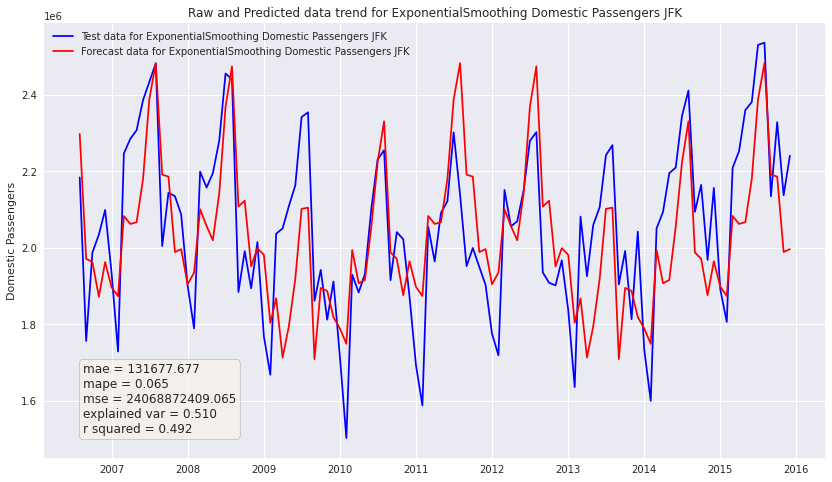

In [ ]:
exp_smooth_pred = plot_predictions(
    y_true=test['Domestic Passengers'], 
    y_pred=prediction['forecast'],
    time_series_name="ExponentialSmoothing Domestic Passengers JFK",
    value_name="Domestic Passengers"
)

The **results from their testing show promise**, illustrating that there is an opportunity for better tuning to make this algorithm’s implementation better. Armed with this knowledge and the results, **this team can be ready to present their findings to the larger team** in an adjudication **without spending more precious time on attempting to improve the results at this stage**.

# Evaluation <a name="5"></a>

In a meeting with the business group, the **team needs to show the business that they can solve the problem** and to ensure that they won't choose an approach that they will end up regretting later in the development phase or when (hopefully) the approach makes its way into production. By **having a compelling and unified story regarding the approach** that will solve the business problem, the chances that the project will move along further past this point is slim.

**How does the team decide which approach to choose?** The team needs to look at each of the approaches that have been tested and make a judgment that is based on the evaluation of the performance of the approaches rather than the accuracy of the predictions:

- **Maximizing the predictive power** of the approach.
- **Minimizing the complexity of the solution** as much as is practicable to still solve the problem.
- Evaluating and **estimating the difficulty in developing the solution** for purposes of realistic scoping for delivery dates.
- **Estimating the total cost of ownership** for (re)training and inference.
- **Evaluating the scalability** of the solution.

Through focusing on these aspects during the evaluation phase, the team can decide upon an approach to build an MVP that aims to **reduce** the vast majority of **reasons why ML projects fail** due to delays or cost. The figure below shows these criteria and how they fit into the overall prototyping phase of ML project work.

![](https://i.ibb.co/mCSxmYY/ml-experimentation-evaluation.png)

## Evaluating prototypes properly <a name="5.1"></a>

We’ve discussed previously the importance of **creating compelling visualizations to illustrate in an easy-to-consume format for both the ML teams and the business unit**, but that’s only part of the story for deciding on one ML approach versus another. The ML teams must not present only the accuracy that a particular solution brings. The **predictive power** of an algorithm, when speaking in an ML Engineering sense, **is only one aspect of consideration among so many more**. 

Let’s move through how the particular forecasting project team will evaluate their testing to settle on the best approach that they tested. The team meets, showing code to one another, reviewing the different test runs with the parameters that were tested, and assembles an agreed-upon comparison of relative difficulty. For some models (such as the VAR model or ElasticNet Regressor), the ML team decides to not include these results in the analysis due to the overwhelmingly poor results that they got and to not show them to the business to avoid distracting from the real purpose of the decision meeting.

What the team ends up coming up with is shown in the next figure, a relatively easy to read **matrix of difficulties associated with each approach** from a truly holistic perspective, **evaluating everything from time-to-delivery** (the complexity of implementing and tuning) to **cost of ownership** (complexity and cost of training, as well as inference) and the estimated **forecasting accuracy**.

![](https://i.ibb.co/rc1pmRv/model-evaluation-metrix.png)

**Governance considerations** may also **play a part in the choice of algorithm**. In particular, highly regulated environments where decisions must be explained (e.g., financial services) cannot use opaque algorithms, like neural networks, and have to favor simpler techniques, such as decision trees. Explainability techniques are becoming increasingly important as global concerns grow about the impact of AI. A review of the **techniques** most commonly use today is available in the notebook [ML Interpretability](https://nbviewer.jupyter.org/github/victorviro/Machine-Learning-Python/blob/master/Machine_Learning_Interpretability_with_InterpretML.ipynb)

It’s worthwhile, at the stage **after prototyping**, to **think** deeply about **what it’s going to be like to build this solution**, and **what is it going to mean to mantain it throughout its lifecycle**. Is anyone going to want to improve upon it? Will they be able to? Is this something that will be relatively straightforward to troubleshoot should the predictions start to become poor?

If we’re unsure of any of these aspects of the proposed group of solutions, it’s best to either discuss these topics amongst the team until consensus is arrived at, or, at the very least, don’t propose it as a potential solution to the business. We must choose wisely at this point because once we commit, it’s going to be challenging to pivot to another approach (but not impossible).

## Make a call on the direction we’re going in <a name="5.2"></a>

Everyone concluded that Holt-Winters Exponential Smoothing seems the safest option for building these forecasts, so we can start talking about architecture and code. Before any code is written though, the team needs to have **another planning session**. This is the time **for the hard questions**. It’s not important to have answers to all of these questions immediately, but they’re all going to need to be answered or flagged for research to get a solid answer within the first sprint after the official project kick-off date.

Let’s run through some of these pressing questions that the team will need to ask themselves in order **to properly estimate what the scope of work is going to be and how the architecture of the solution will need to be designed to meet the business goals**.

**1. How often does this need to run?**

Since this is an autoregressive model, if the model is not **re-trained at a high-frequency**, the predictions will not adapt to recent new data that is coming in. Having as up-to-date training of the model as possible can make sure that the forecasts adapt to the changing trend accurately.

**Tip**: Don’t ever ask the business "How often do you need the predictions?". They will usually spout off some ridiculously short time period. Instead, ask, "At what point will the predictions become irrelevant?".

The business is going to need to provide a minimum and maximum SLA (service level agreement) for the "freshness" of these predictions.

**2. Where is the data for this right now?**

Since the data is provided by an **external data feed**, we need to think about how to create a stable and reliable **ETL** ingestion for this data. The freshness of this data needs to meet the requirements to the answer to the previous question (the SLA being requested).

We need to bring in the Data Engineering team to ensure that they are prioritizing the acquisition of this feed before we’re thinking of going into production. If they are unable to commit to an acceptable date, we will have to write this ETL ourselves, increasing our project scope.

**3. Where are the forecasts going to be stored?**

Related to the answer to question 7, understanding the **consumption patterns associated with these predictions will inform where we’re going to need to put the predictions** and how they’re going to be stored.

- Are the users going to be using BI (business intelligence) style queries to build visualizations in an ad-hoc manner? Then we can probably write the data to an RDBMS source that we have in-house.

- Is this going to be queried very frequently by hundreds (or thousands) of users? Is the data going to be made available as a service for a web front-end? If so, we’re going to have to think about storing the predictions as sorted Arrays in a NoSQL database. We’ll need to build a REST API in front of this data if we’re going to be serving to a front-end service, which will increase the scope of work.

**4. How are we setting up our code base?**

Is this going to be a new project code base, or are we going to let this code live with other ML projects in a common repo? Are we pursuing a full object-oriented approach with the modular design, or will we be attempting to do functional programming?

What is our **deployment strategy** going to be for future improvements? Are we going to use a **CI/CD** system, gitflow releases, or standard git? Where are our metrics associated with each run going to live? **Where** are we going to **log our parameters, auto-tuned hyperparameters**, and visualizations for reference?

It’s not critical to have answers to questions regarding development immediately at this point, but the team lead and architect should be considering these aspects of the project development very soon and should be making a well-considered set of decisions regarding these elements.

**5. Where is this going to run for training?**

We probably run the training on a cloud service, rather than on our laptops.

**6. Where is the inference going to run?**

We definitely should run production ML inference in the cloud.

**7. How are we going to get the predictions to the end-users?**

As stated in the answer to question 3, getting the predictions to the end-users is by far the most overlooked and yet most critical part of any ML project that strives to be useful.

- Do you need to serve it on a webpage? Now would be a good time to have a conversation with some front-end and/or full-stack developers.

- Does it need to be part of a BI report? The Data Engineering and BI Engineering teams should be consulted now.

- Does it need to be stored for ad-hoc SQL queries by analysts?

**8. How much existing code do we have that can be used for this project?**

If we have utility packages already developed, we can review them. If there is existing tech debt in there we can fix and make it better while working on this project.

**9. What is our development cadence and how are we going to work on features?**

Do we have a Project Manager that we’re dealing with? We need to take some time now to explain to them just how much code we’re going to be throwing away during this development process. We need to explain to them gently the chaos of ML project work so that they can get through those first 4 stages of grief and learn to accept it before the project starts.

ML feature work is a unique beast. Huge swaths of code will be developed, only to be completely refactored (or thrown away!) when it’s found that a particular approach is untenable. This is a stark contrast to "pure software development" where a particular functionality is rationally defined and can be fairly accurately scoped.

Understanding that functionality is like this, the pure Agile approach is usually not an effective way of developing code for ML simply due to the nature of changes that might need to be made (swapping a model out, for instance, could incur a large whole-sale refactoring that could consume 2 entire sprints). To help with the different nature of Agile as applied to ML development, it’s critical to organize our stories, our scrums, and our commits accordingly.

# What’s next? <a name="6"></a>

What’s next is building the MVP. 

- It’s working on the demonstratable solution that has fine-tuned accuracy for the model. An explanation showing different approaches for hyperparameter tuning is available in the notebook [Hyperparameter optimization](https://nbviewer.jupyter.org/github/victorviro/Machine-Learning-Python/blob/master/Hyperparameter_Optimization.ipynb).

- Logging testing results in a sustainable and historically referenceable way with experiment tracking systems like [MLflow](https://www.mlflow.org/docs/latest/tracking.html) or [Weights & Biases](https://wandb.ai/site).

# References <a name="7"></a>

- [Machine learning engineering in action](https://livebook.manning.com/book/machine-learning-engineering/)

- [Introducing MLOps](https://www.oreilly.com/library/view/introducing-mlops/9781492083283/)